In [1]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path

/home/ronaldalbert/Documents/env/algo_reasoning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device =  torch.device("cpu")

## Load Pretrained Model

In [3]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.lightning.AlgorithmicReasoningTask import AlgorithmicReasoningTask 
from algo_reasoning.src.specs import CLRS_30_ALGS
from algo_reasoning.src.losses.AlgorithmicReasoningLoss import AlgorithmicReasoningLoss

In [4]:
algorithms = ["heapsort"]

In [5]:
ckpt_path = str(next(Path(f"../checkpoints/checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-hidden_reg=0.5*")))

model = EncodeProcessDecode(algorithms)
loss_fn = AlgorithmicReasoningLoss()

model = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn).model.to(device)

In [6]:
# Calculating embeddings with model reg = 0.0

ckpt_path = str(next(Path(f"../checkpoints/checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-hidden_reg=0.0*")))

model = EncodeProcessDecode(algorithms)
loss_fn = AlgorithmicReasoningLoss()

model_0 = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn).model.to(device)

In [7]:
# Calculating embeddings with model reg = 0.0

ckpt_path = str(next(Path(f"../checkpoints/checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-hidden_reg=0.1*")))

model = EncodeProcessDecode(algorithms)
loss_fn = AlgorithmicReasoningLoss()

model_1 = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn).model.to(device)

# Graph Fourier Analysis of Algorithmic Embeddings

## Toy Example: Graph Fourier Transform of BFS Embeddings

In [8]:

def fourier_transform(embeddings, nb_nodes):
    """
    Compute the Fourier Transform of the embeddings.

    Args:
        embeddings: a tensor of shape (batch_size, sequence_length, embedding_dim)

    Returns:
        a tensor of shape (batch_size, sequence_length, embedding_dim)
    """

    laplacian = torch.diag(torch.ones(nb_nodes, device=device)*nb_nodes) - torch.ones((nb_nodes, nb_nodes), device=device)
    result = torch.linalg.eigh(laplacian)
    eigenvalues = result.eigenvalues
    eigenvectors = result.eigenvectors
    
    eigenvalues[torch.isclose(eigenvalues, torch.tensor(0.))] = 0.

    return eigenvectors.T@embeddings, eigenvectors, eigenvalues

In [9]:
# Load dataset
algorithm_args = {
    'p': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

nb_nodes = 16
ds = CLRSDataset(algorithms, nb_nodes, 32, 1000, seed=7, algorithms_args=algorithm_args)

In [10]:
obj = next(iter(ds)).to(device=device)

In [11]:
obj.max_length

tensor(88)

In [12]:
output = model(obj)
embeddings = output.hidden_embeddings
embeddings.shape

torch.Size([32, 88, 16, 128])

In [13]:
fourier_embeddings, eigenvectors, eigenvalues = fourier_transform(embeddings, nb_nodes)

<BarContainer object of 16 artists>

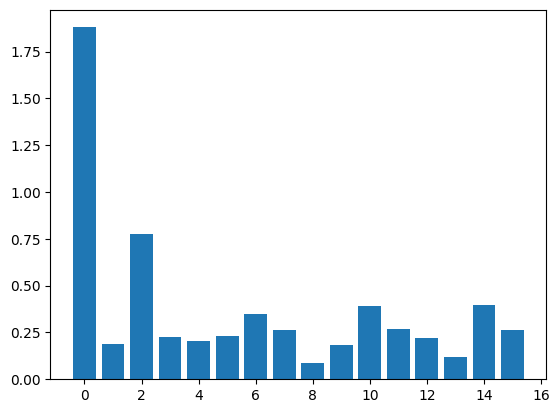

In [14]:
import matplotlib.pyplot as plt

plot_data = torch.mean(torch.abs(fourier_embeddings), dim=3)

plt.bar(x=[i for i in range(nb_nodes)], height=plot_data[0,0].detach().cpu().numpy())

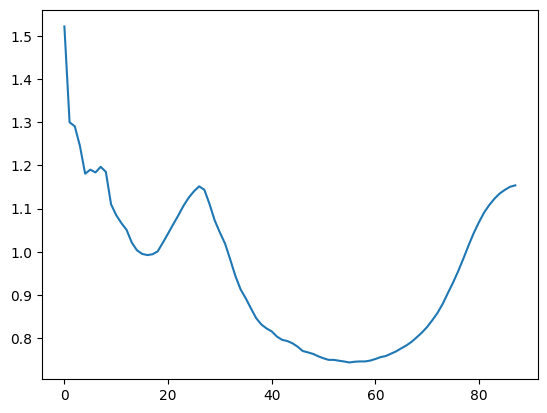

In [15]:
import matplotlib.pyplot as plt
difference_over_length = torch.mean(torch.abs(plot_data[:, :, 0] - torch.mean(plot_data[:, :, 1:])), dim=0)

plt.plot(difference_over_length.detach().cpu().numpy())

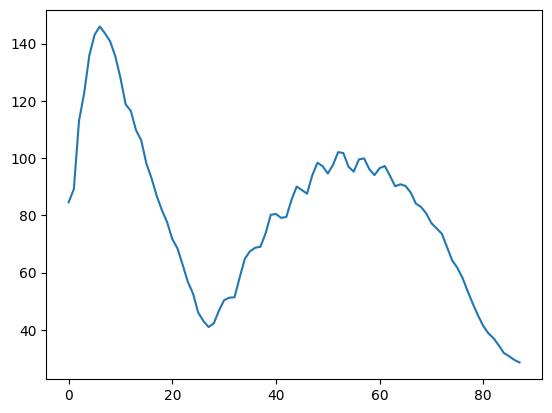

In [16]:
laplacian = torch.diag(torch.ones(nb_nodes, device=device)*nb_nodes) - torch.ones((nb_nodes, nb_nodes), device=device)
_embeddings = embeddings.clone()[0, :, :]
variability = torch.sum((_embeddings.transpose(1, 2)@laplacian)*_embeddings.transpose(1,2), dim=2)

plt.plot(torch.mean(variability, dim=1).detach().cpu().numpy())

In [17]:
def _mean_corr_coef(embeddings):
    mean_corr_coef = None
    for i in range(embeddings.size(0)):
        if mean_corr_coef is None:
            mean_corr_coef = embeddings[i, 15].corrcoef()
        else:
            mean_corr_coef += embeddings[i, 15].corrcoef()

    mean_corr_coef = mean_corr_coef/embeddings.size(0)

    return mean_corr_coef

In [ ]:
import pandas as pd

def calculate_mean_corr_coef(algos, model):
    mean_corr = []
    
    for algo in CLRS_30_ALGS:
        nb_nodes = 16
        ds = CLRSDataset(algorithms, nb_nodes, 8, 1000, seed=7, algorithms_args=algorithm_args)
    
        obj = next(iter(ds)).to(device=device)
    
        output = model(obj)
        embeddings = output.hidden_embeddings
        
        mean_corr.append(_mean_corr_coef(embeddings).mean())

    return mean_corr

mean_corr_coef = calculate_mean_corr_coef(CLRS_30_ALGS, model)
mean_corr_coef_0 = calculate_mean_corr_coef(CLRS_30_ALGS, model_0)
mean_corr_coef_1 = calculate_mean_corr_coef(CLRS_30_ALGS, model_1)

In [ ]:
mean_corr_df = pd.DataFrame({"algoritmhs": CLRS_30_ALGS, 
                             "mean_corr_0.5":mean_corr_coef, 
                             "mean_corr_0.1":mean_corr_coef_1,
                             "mean_corr_0.0":mean_corr_coef_0})

mean_corr_df